In [1]:
#!/usr/bin/env python
"""
Demo for tomography test problem on a large scale problem to test the l-curve regularization parameter selection in the package
--------------------------------------------------------------------------
Created in 2025 for TRIPs-Py library
"""
__authors__ = "Toluwani Okuanola and Mirjeta Pasha"
__affiliations__ = "Tufts University and Virginia Tech"
__copyright__ = "Copyright 2025, TRIPs-Py library"
__license__ = "Apache"
__version__ = "1.0"
__email__ = "toluwaokunola@gmail.com and mirjeta.pasha1@gmail.com"

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import astra
from trips.utilities.phantoms import *
from venv import create
import pylops
from trips.solvers.GKS import *
from trips.solvers.MMGKS import *
from trips.solvers.Tikhonov import *
from trips.solvers.tSVD import *
from trips.utilities.helpers import *
from trips.solvers.CGLS import *
from trips.solvers.GMRES import GMRES
from trips.solvers.Hybrid_GMRES import *
from trips.solvers.Hybrid_LSQR import *
from trips.utilities.operators import *

#### In this notebook we illustrate how to use the Tomography class. The main features are:
1. Define e tomography problem. Show how the forward operator can be accessed as a matrix (for relatively small problems) or only as an operator.
 - 1.1 We show how to use SVD, compute the singular values of the operator, and illustrate the truncated SVD solution
 - 1.2 We use regularization methods for computing an approximate solution
2. Define a tomography problem by loading some saved data


#### 1. Define e tomography problem

###### We define an operator, choose a phantom of any given size and plot the true phantom and the sinograpm as follows:

In [3]:
# Define an object of the class Tomogrpahy
Tomo = Tomography()
# Specify the dimensions of the phantom and the number of angels that we call views
views = 30
nx = 64
ny = 64
# Step 1: Define the true solution throught the function gen_true(). 
# Options are: grains, smooth, tectonic, threephases, ppower
testproblem = 'grains'
(x_true, nx, ny) = Tomo.gen_true(testproblem, nx = nx, ny = ny)
# Step 2: Define the forward operator
A = Tomo.forward_Op(nx, ny, views)
# Generate the data: We can skip Step 1 and generate the sinogram and the operator by the following lines
(A, b_true, p, q, AforMatrixOperation) = Tomo.gen_data(x_true, nx, ny, views)
# Add noise in the true simulated sinogram b_true
# The opt defines the type of the noise. Options are Gaussian, Laplace, and Poisson
# The noise level defines the percentage of the noise added in the data. A value 0.01 means 1% additive noise
(d, delta) = Tomo.add_noise(b_true = b_true, opt = 'Gaussian', noise_level = 0.001)
b_vec = d.reshape((-1,1))

settings
no crime


###### Display the true image, the sinogram without noise and the noisy sinogram

(<Axes: title={'center': 'b'}>,
 Text(0.5, 1.0, 'b'),
 (0.0, 1.0, 0.0, 1.0),
 <matplotlib.image.AxesImage at 0x7fa648809130>)

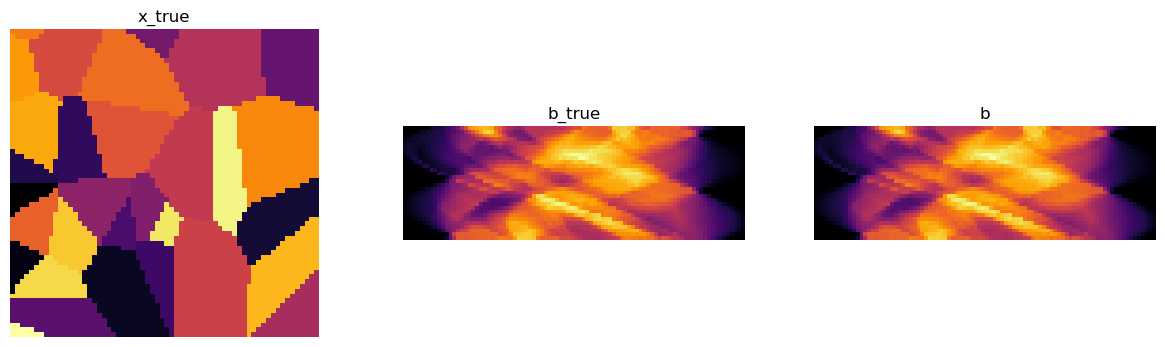

In [13]:
plt.figure(figsize=(15,4))
plt.set_cmap('inferno')
plt.subplot(1,3,1), plt.title('x_true'), plt.axis('off'), plt.imshow(x_true.reshape((nx,ny)))
plt.subplot(1,3,2), plt.title('b_true'), plt.axis('off'), plt.imshow(b_true.reshape((p,q)))
plt.subplot(1,3,3), plt.title('b'), plt.axis('off'), plt.imshow(d.reshape((p,q)))

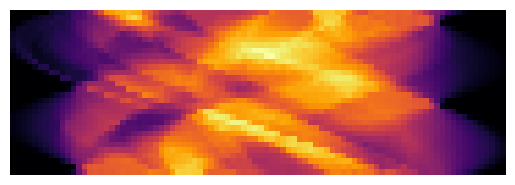

In [14]:
plt.imshow(d.reshape((p, q)))
plt.axis('off')
plt.set_cmap('inferno')

#### 1.2 Compute an approximate solution by using Generalized Krylov Subspace method (GKS)

In [11]:
# Define a derivative operator as a regularization operator
L = gen_first_derivative_operator_2D(nx, ny)
data_vec = d.reshape((-1,1))
# Use GKS to compute an approximate solution
(x_gks_dp, info_gks_dp) = GKS(A, data_vec, L, projection_dim=2, n_iter = 100, regparam = 'dp', x_true = x_true.reshape(-1,1), delta = delta)

running GKS...: 100%|██████████| 100/100 [00:04<00:00, 21.42it/s]


In [13]:
x_gks_dp.shape

(4096, 1)

In [8]:
# Define a derivative operator as a regularization operator
L = gen_first_derivative_operator_2D(nx, ny)
data_vec = d.reshape((-1,1))
# Use GKS to compute an approximate solution
(x_gks_lc, info_gks_lc) = GKS(A, data_vec, L, projection_dim=2, n_iter = 100, regparam = 'l_curve', x_true = x_true.reshape(-1,1), delta = delta)

running GKS...: 100%|██████████| 100/100 [00:42<00:00,  2.34it/s]


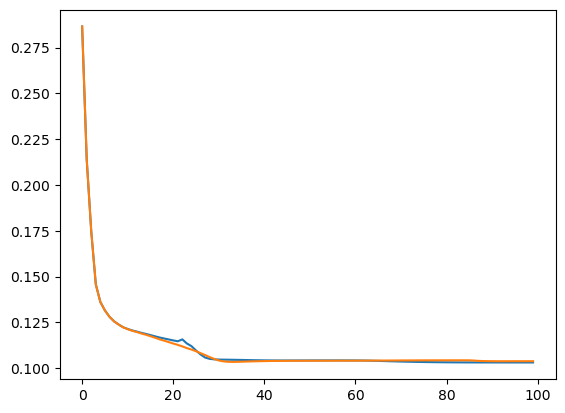

In [12]:
plt.plot(info_gks_dp['relError'])
plt.plot(info_gks_lc['relError'])

(<Axes: title={'center': 'x_gks_lc'}>,
 Text(0.5, 1.0, 'x_gks_lc'),
 (0.0, 1.0, 0.0, 1.0),
 <matplotlib.image.AxesImage at 0x7fae502afeb0>)

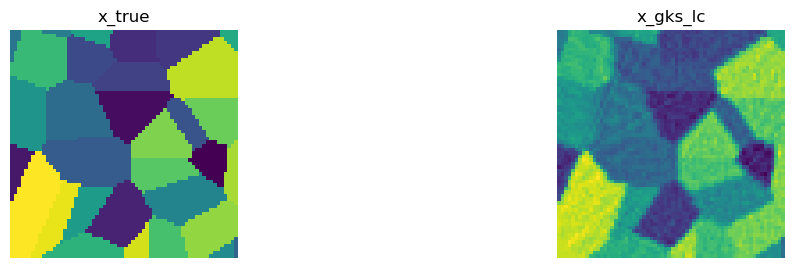

In [16]:
# Display the true desired vs the naive computed solution and vs the approximate regularized computed solution 
plt.figure(figsize=(10,4))
plt.subplot(1,3,1), plt.title('x_true'), plt.axis('off'), plt.imshow(x_true.reshape((nx,ny)))
plt.subplot(1,3,3), plt.title('x_gks_lc'), plt.axis('off'), plt.imshow(x_gks_lc.reshape((nx, ny)))

#### Solve the problem with MMGKS using Discrepancy Principle to select the regularization parameter

In [17]:
# Compute a solution by GKS
# Define a derivative operator as a regularization operator
L = gen_first_derivative_operator_2D(nx, ny)
data_vec = d.reshape((-1,1))
# Use GKS to compute an approximate solution
(x_mmgks_dp, info_mmgks_dp) = MMGKS(A, data_vec, L, pnorm=2, qnorm=1, projection_dim=2, n_iter =100, regparam = 'dp', x_true = x_true.reshape((-1,1)), delta = delta, epsilon = 0.1)

running MMGKS...: 100%|██████████| 100/100 [00:05<00:00, 17.89it/s]


#### Solve the problem with MMGKS using l curve method to select the regularization parameter

In [18]:
# Compute a solution by GKS
# Define a derivative operator as a regularization operator
L = gen_first_derivative_operator_2D(nx, ny)
data_vec = d.reshape((-1,1))
# Use GKS to compute an approximate solution
(x_mmgks_lc, info_mmgks_lc) = MMGKS(A, data_vec, L, pnorm=2, qnorm=1, projection_dim=2, n_iter =100, regparam = 'l_curve', x_true = x_true.reshape((-1,1)), delta = delta, epsilon = 0.1)

running MMGKS...: 100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


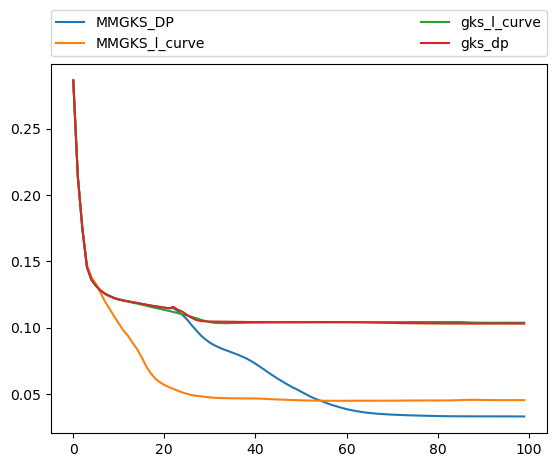

In [20]:
plt.plot(info_mmgks_dp['relError'], label = 'MMGKS_DP')
plt.plot(info_mmgks_lc['relError'], label = 'MMGKS_l_curve')
plt.plot(info_gks_lc['relError'], label='gks_l_curve')
plt.plot(info_gks_dp['relError'], label = 'gks_dp')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

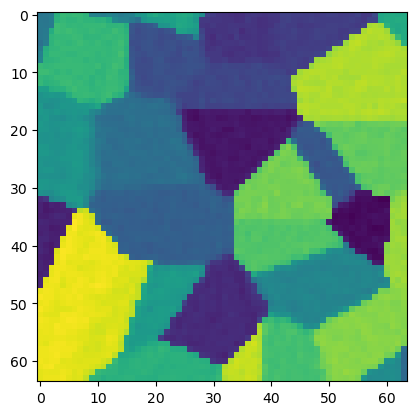

In [21]:
plt.imshow(x_mmgks_dp.reshape((nx,ny)))

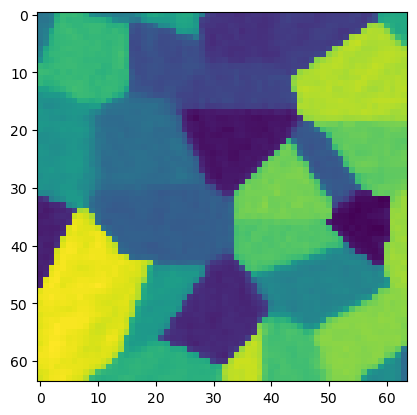

In [22]:
plt.imshow(x_mmgks_lc.reshape((nx,ny)))

###### Display the true image, the sinogram without noise and the noisy sinogram

(<Axes: title={'center': 'b'}>,
 Text(0.5, 1.0, 'b'),
 (0.0, 1.0, 0.0, 1.0),
 <matplotlib.image.AxesImage at 0x7fae50386a60>)

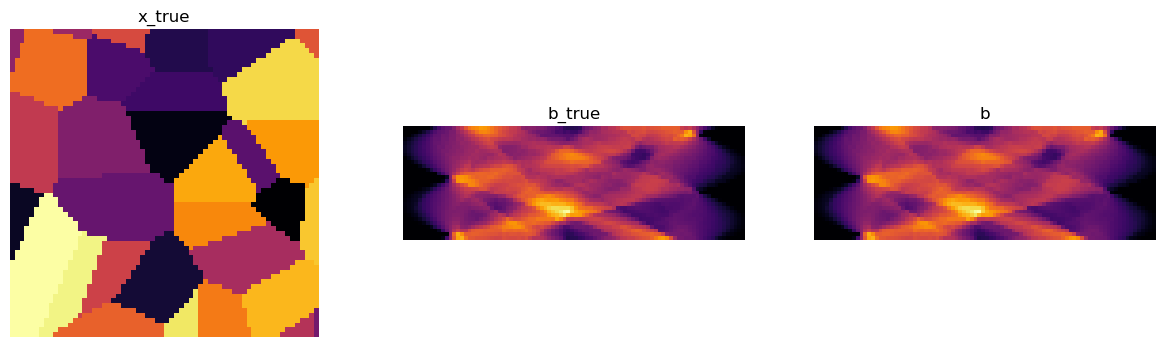

In [23]:
plt.figure(figsize=(15,4))
plt.set_cmap('inferno')
plt.subplot(1,3,1), plt.title('x_true'), plt.axis('off'), plt.imshow(x_true.reshape((nx,ny)))
plt.subplot(1,3,2), plt.title('b_true'), plt.axis('off'), plt.imshow(b_true.reshape((p,q)))
plt.subplot(1,3,3), plt.title('b'), plt.axis('off'), plt.imshow(d.reshape((p,q)))